![HSV-AI Logo](https://github.com/HSV-AI/hugo-website/blob/master/static/images/logo_v9.png?raw=true)

# Implicit Recommendation from ECommerce Data

Some of the material for this work is based on [A Gentle Introduction to Recommender Systems with Implicit Feedback](https://jessesw.com/Rec-System/) by Jesse Steinweg Woods. This tutorial includes an implementation of the Alternating Least Squares algorithm and some other useful functions (like the area under the curve calculation). Other parts of the tutorial are based on a previous version of the Implicit library and had to be reworked.

The dataset used for this work is from Kaggle [E-Commerce Data, Actual transactions from UK retailer](https://www.kaggle.com/carrie1/ecommerce-data)


# Global Imports

In [116]:
import pandas as pd
import numpy as np
import random
from matplotlib import pyplot as plt
import implicit
import scipy
from sklearn import metrics
from pandas.api.types import CategoricalDtype


# Data Exploration

In [7]:
# It appears that the csv file is encoded as iso-8859-1 (I guessed) and has to be loaded using the encoding parameter.
df = pd.read_csv('../data/external/ecommerce/data.csv', encoding='iso-8859-1')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [18]:
print('Unique invoices', len(pd.unique(df['InvoiceNo'])))
print('Unique products', len(pd.unique(df['StockCode'])))
print('Total rows', len(df))

Unique invoices 25900
Unique products 4070
Total rows 541909


## Checking for missing values

It looks like the InvoiceNo, StockCode, and Quantity are always available. That is all that we will be using from this dataset, so the rest is fine.

In [8]:
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Let's look at the number of products and see how they are distributed among the orders. We can use the value_counts method from pandas to get an idea of how often each product is ordered.

There are 4070 unique products

Here are the counts of products ordered from largest to smallest
[2313 2203 2159 ...    1    1    1]

And a graph of what the curve looks like:


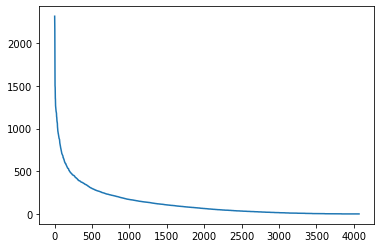

In [9]:
product_counts = df['StockCode'].value_counts().to_numpy()
print('There are', len(product_counts), 'unique products\n')
print('Here are the counts of products ordered from largest to smallest')
print(product_counts)
print('\nAnd a graph of what the curve looks like:')
plt.plot(product_counts) 
plt.show()

It appears that there are a few items in the store that sell a LOT, and most that are sold a few times. This seems normal for a retail store. Let's take a quick look at the most purchased item to see if it makes sense.

In [10]:
df['StockCode'].value_counts().head()

85123A    2313
22423     2203
85099B    2159
47566     1727
20725     1639
Name: StockCode, dtype: int64

In [23]:
df[df['StockCode']=='85123A'].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
49,536373,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 9:02,2.55,17850.0,United Kingdom
66,536375,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 9:32,2.55,17850.0,United Kingdom
220,536390,85123A,WHITE HANGING HEART T-LIGHT HOLDER,64,12/1/2010 10:19,2.55,17511.0,United Kingdom
262,536394,85123A,WHITE HANGING HEART T-LIGHT HOLDER,32,12/1/2010 10:39,2.55,13408.0,United Kingdom


We don't have information about the market of the retail store, but looking at a price of 2.55 - this looks like a normal high volume item.

Now we can check the value of each invoice and see what jumps out.

<AxesSubplot:xlabel='InvoiceNo'>

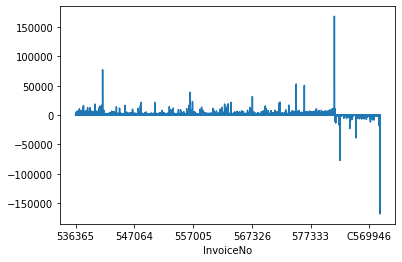

In [225]:
df['StockTotal'] = df['Quantity'] * df['UnitPrice']
totals = df.groupby(df.InvoiceNo)['StockTotal'].sum()
totals.plot()

Well there's something worth looking into. We need to figure out what the negative order totals are. It would have to be either a negative quantity or price - so let's figure out which it is.

In [231]:
print('There are', len(df[df.Quantity < 0]), 'negative quantities')
df[df.Quantity < 0].head()

There are 10624 negative quantities


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,StockTotal
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527.0,United Kingdom,-27.50
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311.0,United Kingdom,-4.65
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548.0,United Kingdom,-19.80
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom,-6.96
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom,-6.96


Now we need to figure out what to do with these. We could throw out all invoices that include negative quanties, or just the items with negative quanties. Let's check to see if we have any mixed invoices.

In [249]:
temp_df = df.groupby(df.InvoiceNo).agg(minQ=('Quantity', 'min'), 
                               maxQ=('Quantity', 'max'))
temp_df[(temp_df.minQ < 0) & (temp_df.maxQ > 0)].head()

,minQ,maxQ
InvoiceNo,,


Given that all negative quantities are on invoices with no purchases, we should be able to remove them.

In [232]:
print('There are', len(df[df.UnitPrice < 0]), 'negative unit prices')

df[df.UnitPrice < 0].head()

There are 2 negative unit prices


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,StockTotal
299983,A563186,B,Adjust bad debt,1,8/12/2011 14:51,-11062.06,NaN,United Kingdom,-11062.06
299984,A563187,B,Adjust bad debt,1,8/12/2011 14:52,-11062.06,NaN,United Kingdom,-11062.06


It looks like we can throw out anything with a negative UnitPrice.

In [247]:
df = df[(df.UnitPrice > 0) & (df.Quantity > 0)]

Now we need to look into those very large sums on the invoice total to see what is happening there.

In [255]:
totals.sort_values(ascending=False)

InvoiceNo
581483     168469.60
541431      77183.60
574941      52940.94
576365      50653.91
556444      38970.00
             ...    
C580605    -17836.46
C550456    -22998.40
C556445    -38970.00
C541433    -77183.60
C581484   -168469.60
Name: StockTotal, Length: 25900, dtype: float64

In [256]:
df[df.InvoiceNo == '581483'].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,StockTotal
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,12/9/2011 9:15,2.08,16446.0,United Kingdom,168469.6


It looks like these were actual orders with a giant quantity. These aren't your average customers, so we may need to try both with the data and without.

Another thing we can do is compute the sparsity of the data. This is useful to see if there is enough overlap between the orders and products to make a useful decision for recommendations.

In [257]:
order_counts = df['InvoiceNo'].value_counts()
num_orders = len(order_counts)
num_items = len(product_counts)
sparsity = 1 - len(df) / (num_orders * num_items)
print(f'number of orders: {num_orders}, number of items: {num_items}')
print(f'matrix sparsity: {sparsity:f}')

number of orders: 19960, number of items: 3362
matrix sparsity: 0.992100


Compare that with the 100k movielens dataset that has:

```
number of users: 943, number of items: 1682
matrix sparsity: 0.936953
```

Given that this is intended to be used for recommendations based in individual orders, we can remove any invoice that has less than 2 items.

In [262]:
minimum_order_size = 2
order_group = df.loc[:, ['InvoiceNo', 'StockCode']].groupby('InvoiceNo').count()
 
multi_order = order_group[(order_group.StockCode >= minimum_order_size)].count()
single_order = order_group[(order_group.StockCode < minimum_order_size)].count()
 
print('Orders with at least',minimum_order_size,'products:',multi_order['StockCode'])
print('Orders with less than',minimum_order_size,'products:',single_order['StockCode'])
 
# We can capture the list of mutiple product orders with this:
order_filter = order_group[(order_group.StockCode >= minimum_order_size)].index.tolist()

Orders with at least 2 products: 18334
Orders with less than 2 products: 1626


In [264]:
filtered_df = df[df['InvoiceNo'].isin(order_filter)].copy()
print('Original dataframe length:', len(df))
print('Filtered dataframe length:', len(filtered_df))

Original dataframe length: 530104
Filtered dataframe length: 528478


There are 3914 unique products


And a graph of what the curve looks like:


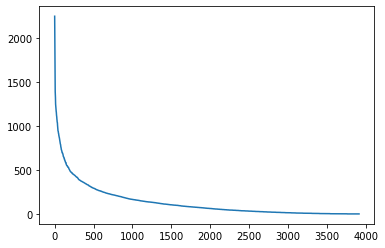

number of orders: 18334, number of items: 3914
matrix sparsity: 0.992613


In [265]:
product_counts = filtered_df['StockCode'].value_counts().to_numpy()
print('There are', len(product_counts), 'unique products\n')
print('\nAnd a graph of what the curve looks like:')
plt.plot(product_counts) 
plt.show()
 
order_counts = filtered_df['InvoiceNo'].value_counts()
num_orders = len(order_counts)
num_items = len(product_counts)
sparsity = 1 - len(df) / (num_orders * num_items)
print(f'number of orders: {num_orders}, number of items: {num_items}')
print(f'matrix sparsity: {sparsity:f}')

In [44]:
filtered_df['StockCode'] = filtered_df['StockCode'].astype(str)

In [294]:
item_lookup = filtered_df[['StockCode', 'Description']].drop_duplicates() # Only get unique item/description pairs
item_lookup['StockCode'] = item_lookup.StockCode.astype(str) # Encode as strings for future lookup ease

price_lookup = filtered_df[['StockCode', 'UnitPrice']].drop_duplicates()
price_lookup['StockCode'] = price_lookup.StockCode.astype(str)

In [266]:
selected_df = filtered_df[['InvoiceNo', 'StockCode', 'Quantity']]
selected_df.info()
selected_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 528478 entries, 0 to 541908
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   InvoiceNo  528478 non-null  object
 1   StockCode  528478 non-null  object
 2   Quantity   528478 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 16.1+ MB


,InvoiceNo,StockCode,Quantity
0,536365,85123A,6
1,536365,71053,6
2,536365,84406B,8
3,536365,84029G,6
4,536365,84029E,6


In [269]:
invoices = list(np.sort(selected_df.InvoiceNo.unique())) # Get our unique customers
products = list(selected_df.StockCode.unique()) # Get our unique products that were purchased
quantity = list(selected_df.Quantity) # All of our purchases

cols = selected_df.InvoiceNo.astype(CategoricalDtype(categories=invoices, ordered=True)).cat.codes 
# Get the associated row indices
rows = selected_df.StockCode.astype(CategoricalDtype(categories=products, ordered=True)).cat.codes 
# Get the associated column indices
purchases_sparse = scipy.sparse.csr_matrix((quantity, (rows, cols)), shape=(len(products), len(invoices)))

In [270]:
purchases_sparse

<3914x18334 sparse matrix of type '<class 'numpy.int64'>'
	with 517976 stored elements in Compressed Sparse Row format>

In [271]:
matrix_size = purchases_sparse.shape[0]*purchases_sparse.shape[1] # Number of possible interactions in the matrix
num_purchases = len(purchases_sparse.nonzero()[0]) # Number of items interacted with
sparsity = 100*(1 - (num_purchases/matrix_size))
sparsity

99.27817554903982

# Training & Test Datasets

We will use the function below to create a training and test dataset from the tutorial linked at the top. The test dataset masks some percentage of purchases to tested later with a recommendation.

In [273]:
def make_train(ratings, pct_test = 0.2):
    '''
    This function will take in the original user-item matrix and "mask" a percentage of the original ratings where a
    user-item interaction has taken place for use as a test set. The test set will contain all of the original ratings, 
    while the training set replaces the specified percentage of them with a zero in the original ratings matrix. 
    
    parameters: 
    
    ratings - the original ratings matrix from which you want to generate a train/test set. Test is just a complete
    copy of the original set. This is in the form of a sparse csr_matrix. 
    
    pct_test - The percentage of user-item interactions where an interaction took place that you want to mask in the 
    training set for later comparison to the test set, which contains all of the original ratings. 
    
    returns:
    
    training_set - The altered version of the original data with a certain percentage of the user-item pairs 
    that originally had interaction set back to zero.
    
    test_set - A copy of the original ratings matrix, unaltered, so it can be used to see how the rank order 
    compares with the actual interactions.
    
    user_inds - From the randomly selected user-item indices, which user rows were altered in the training data.
    This will be necessary later when evaluating the performance via AUC.
    '''
    test_set = ratings.copy() # Make a copy of the original set to be the test set. 
    test_set[test_set != 0] = 1 # Store the test set as a binary preference matrix
    training_set = ratings.copy() # Make a copy of the original data we can alter as our training set. 
    nonzero_inds = training_set.nonzero() # Find the indices in the ratings data where an interaction exists
    nonzero_pairs = list(zip(nonzero_inds[0], nonzero_inds[1])) # Zip these pairs together of user,item index into list
    random.seed(0) # Set the random seed to zero for reproducibility
    num_samples = int(np.ceil(pct_test*len(nonzero_pairs))) # Round the number of samples needed to the nearest integer
    samples = random.sample(nonzero_pairs, num_samples) # Sample a random number of user-item pairs without replacement
    user_inds = [index[0] for index in samples] # Get the user row indices
    item_inds = [index[1] for index in samples] # Get the item column indices
    training_set[user_inds, item_inds] = 0 # Assign all of the randomly chosen user-item pairs to zero
    training_set.eliminate_zeros() # Get rid of zeros in sparse array storage after update to save space
    return training_set, test_set, list(set(user_inds)) # Output the unique list of user rows that were altered  


In [272]:
product_train, product_test, product_users_altered = make_train(purchases_sparse, pct_test = 0.2)


# Implicit Recommendation Model

The code below creates and trains one of the models available from the Implicit package. Currently using hyperparameters suggested by various tutorials with no tuning.

In [274]:
alpha = 15

model = implicit.als.AlternatingLeastSquares(factors=64,
                                    regularization=0.1,
                                    iterations=50,
                                    use_native=False)

## BayesianPersonalizedRanking was pretty bad
# model = implicit.bpr.BayesianPersonalizedRanking(factors=31,
#                                     regularization=0.1,
#                                     iterations=50)


# model = implicit.lmf.LogisticMatrixFactorization(factors=32,
#                                     regularization=0.1,
#                                     iterations=50)

model.fit((product_train * alpha).astype('double'))

user_vecs = model.user_factors
item_vecs = model.item_factors

# Deprecated function below
# user_vecs, item_vecs = implicit.alternating_least_squares((product_train*alpha).astype('double'), 
#                                                           factors=32, 
#                                                           regularization = 0.1, 
#                                                           iterations = 50)

# Scoring the Model

Following the tutorial, we will use the area under the Receiver Operating Characteristic curve. 

In [276]:
def auc_score(predictions, test):
    '''
    This simple function will output the area under the curve using sklearn's metrics. 
    
    parameters:
    
    - predictions: your prediction output
    
    - test: the actual target result you are comparing to
    
    returns:
    
    - AUC (area under the Receiver Operating Characterisic curve)
    '''
    fpr, tpr, thresholds = metrics.roc_curve(test, predictions)
    return metrics.auc(fpr, tpr)   


In [289]:
def calc_mean_auc(training_set, altered_users, predictions, test_set):
    '''
    This function will calculate the mean AUC by user for any user that had their user-item matrix altered. 
    
    parameters:
    
    training_set - The training set resulting from make_train, where a certain percentage of the original
    user/item interactions are reset to zero to hide them from the model 
    
    predictions - The matrix of your predicted ratings for each user/item pair as output from the implicit MF.
    These should be stored in a list, with user vectors as item zero and item vectors as item one. 
    
    altered_users - The indices of the users where at least one user/item pair was altered from make_train function
    
    test_set - The test set constucted earlier from make_train function
    
    
    
    returns:
    
    The mean AUC (area under the Receiver Operator Characteristic curve) of the test set only on user-item interactions
    there were originally zero to test ranking ability in addition to the most popular items as a benchmark.
    '''
    
    
    store_auc = [] # An empty list to store the AUC for each user that had an item removed from the training set
    popularity_auc = [] # To store popular AUC scores
    pop_items = np.array(test_set.sum(axis = 0)).reshape(-1) # Get sum of item iteractions to find most popular
    item_vecs = predictions[1]
    for user in altered_users: # Iterate through each user that had an item altered
        training_row = training_set[user,:].toarray().reshape(-1) # Get the training set row
        zero_inds = np.where(training_row == 0) # Find where the interaction had not yet occurred
        # Get the predicted values based on our user/item vectors
        user_vec = predictions[0][user,:]
        pred = user_vec.dot(item_vecs).toarray()[0,zero_inds].reshape(-1)
        # Get only the items that were originally zero
        # Select all ratings from the MF prediction for this user that originally had no iteraction
        actual = test_set[user,:].toarray()[0,zero_inds].reshape(-1) 
        # Select the binarized yes/no interaction pairs from the original full data
        # that align with the same pairs in training 
        pop = pop_items[zero_inds] # Get the item popularity for our chosen items
        store_auc.append(auc_score(pred, actual)) # Calculate AUC for the given user and store
        popularity_auc.append(auc_score(pop, actual)) # Calculate AUC using most popular and score
    # End users iteration
    
    return float('%.3f'%np.mean(store_auc)), float('%.3f'%np.mean(popularity_auc))  
   # Return the mean AUC rounded to three decimal places for both test and popularity benchmark


In [290]:
test, popular = calc_mean_auc(product_train, product_users_altered, 
              [scipy.sparse.csr_matrix(item_vecs), scipy.sparse.csr_matrix(user_vecs.T)], product_test)

print('Our model scored',test,'versus a score of',popular,'if we always recommended the most popular item.')

Our model scored 0.879 versus a score of 0.8 if we always recommended the most popular item.


In [301]:
recommended_price = []
for user in product_users_altered:
    recommendations = model.recommend(0, user_items)
    index = recommendations[0][0]
    price = price_lookup[price_lookup.StockCode == products[index]].values
    recommended_price.append(price[0][1])
    
total_recommended = np.sum(recommended_price)

print('After recommending',len(product_users_altered),'items, there would be an increase of',
      "${:,.2f}".format(total_recommended*test),'in additional purchases.')

After recommending 3524 items, there would be an increase of $7,898.87 in additional purchases.


# Spot Checking

Now that we have a pretty good idea of the model performance overall, we can spot check a few things like finding similar items and checking item recommendations for an existing invoice.

In [279]:
related = model.similar_items(69)
for rel in related:
    index = rel[0]
    prob = rel[1]
    item = item_lookup[item_lookup.StockCode == products[index]].values
    print(prob, item[0][1])

1.0000001 60 TEATIME FAIRY CAKE CASES
0.64660966 PACK OF 60 PINK PAISLEY CAKE CASES
0.57605165 72 SWEETHEART FAIRY CAKE CASES
0.5484657 60 CAKE CASES DOLLY GIRL DESIGN
0.52495426 PACK OF 60 SPACEBOY CAKE CASES
0.5079048 PACK OF 60 DINOSAUR CAKE CASES
0.496506 PACK OF 72 RETROSPOT CAKE CASES
0.48574603 SET OF 36 TEATIME PAPER DOILIES
0.47948703 IVORY PAPER CUP CAKE CASES 
0.46128058 PACK OF 60 MUSHROOM CAKE CASES


In [280]:
user_items = (product_train * alpha).astype('double').T.tocsr()
def recommend(order):
    print('Order Contents:')
    print(filtered_df[filtered_df.InvoiceNo == invoices[order]].loc[:, ['StockCode', 'Description']])
    print('Recommendations:')
    recommendations = model.recommend(order, user_items)
    for rec in recommendations:
        index = rec[0]
        prob = rec[1]
        stock_code = products[index]
        item = item_lookup[item_lookup.StockCode == stock_code].values
        print(prob, stock_code, item[0][1])    

In [281]:
recommend(1)

Order Contents:
  StockCode                Description
7     22633     HAND WARMER UNION JACK
8     22632  HAND WARMER RED POLKA DOT
Recommendations:
0.72136694 22867 HAND WARMER BIRD DESIGN
0.7183175 22632 HAND WARMER RED POLKA DOT
0.7104223 22866 HAND WARMER SCOTTY DOG DESIGN
0.69523984 22865 HAND WARMER OWL DESIGN
0.66485775 23439 HAND WARMER RED LOVE HEART
0.520213 22834 HAND WARMER BABUSHKA DESIGN
0.40574443 22114 HOT WATER BOTTLE TEA AND SYMPATHY
0.38092676 22111 SCOTTIE DOG HOT WATER BOTTLE
0.34227479 23355 HOT WATER BOTTLE KEEP CALM
0.31270087 22112 CHOCOLATE HOT WATER BOTTLE


In [282]:
recommend(8889)

Order Contents:
       StockCode                          Description
247432    84877D            BLUE ROUND COMPACT MIRROR
247433     20914  SET/5 RED RETROSPOT LID GLASS BOWLS
247434     20992           JAZZ HEARTS PURSE NOTEBOOK
247435     84987      SET OF 36 TEATIME PAPER DOILIES
247436     22847          BREAD BIN DINER STYLE IVORY
247437    37479P        CUBIC MUG FLOCK PINK ON BROWN
247438     23229            VINTAGE DONKEY TAIL GAME 
247439     21034         REX CASH+CARRY JUMBO SHOPPER
247440     20615         BLUE POLKADOT PASSPORT COVER
247441     22131     FOOD CONTAINER SET 3 LOVE HEART 
247442     23171             REGENCY TEA PLATE GREEN 
247443     23173                REGENCY TEAPOT ROSES 
247444     20622                  VIP PASSPORT COVER 
247445     22423             REGENCY CAKESTAND 3 TIER
247446     22699     ROSES REGENCY TEACUP AND SAUCER 
247447     22698       PINK REGENCY TEACUP AND SAUCER
247448     22697      GREEN REGENCY TEACUP AND SAUCER
247449     2

# F Score

Keeping this down here in case we want to compute F Score to go along with AUC.

In [268]:
def get_f_score(precision, recall):
  denominator = precision + recall
  if(denominator == 0):
    return 0
  return 2 * (precision * recall) / denominator

In [267]:
def precision_recall_at_k(predictions, k=10, threshold=.75):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls